## 모델학습 데이터 준비 

In [2]:
!export TMPDIR=’/var/tmp’
!pip install tensorflow
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |██████████████████              | 331.5 MB 124.2 MB/s eta 0:00:03

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 589.8 MB 12 kB/s               
     |████████████████████████████████| 2.2 MB 56.3 MB/s            
     |████████████████████████████████| 5.1 MB 94.2 MB/s            
     |████████████████████████████████| 5.5 MB 81.5 MB/s            
     |████████████████████████████████| 5.6 MB 62.6 MB/s            
     |████████████████████████████████| 80 kB 20.5 MB/s            
     |████████████████████████████████| 24.5 MB 92.1 MB/s            
     |████████████████████████████████| 1.1 MB 69.7 MB/s            
     |████████████████████████████████| 294 kB 103.5 MB/s            
     |████████████████████████████████| 57 kB 12.9 MB/s            
     |████████████████████████████████| 65 kB 10.3 MB/s             
     |████████████████████████████████| 4.8 MB 61.9 MB/s            
     |████████████████████████████████| 133 kB 84.5 MB/s            
     |████████████████████████████████| 18.2 MB 50.7 MB/s            
     |████████████████████████

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
# 학습데이터 다운로드
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [17]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


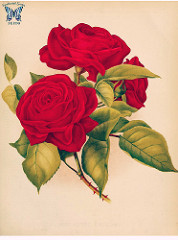

In [18]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [19]:
batch_size = 32
img_height = 180
img_width = 180

# 훈련 데이터
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 검증 데이터
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [20]:
# 클래스 출력
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# 데이터 표준화
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0143791055 0.9679742


## 모델학습

In [25]:
# 과적합을 방지하기위한 데이터 증강 레이어
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [26]:
# 모델 만들기
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [27]:
#모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 훈련, 대략 30분 소요 (gpu가 아닌 cpu 사용)
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 961ms/step - accuracy: 0.3026 - loss: 1.5330 - val_accuracy: 0.5259 - val_loss: 1.1616
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 940ms/step - accuracy: 0.5537 - loss: 1.1319 - val_accuracy: 0.5640 - val_loss: 1.0374
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 925ms/step - accuracy: 0.6282 - loss: 0.9684 - val_accuracy: 0.6172 - val_loss: 0.9632
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.6356 - loss: 0.9326 - val_accuracy: 0.6471 - val_loss: 0.8884
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 926ms/step - accuracy: 0.6810 - loss: 0.8288 - val_accuracy: 0.6403 - val_loss: 0.9481
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 925ms/step - accuracy: 0.6913 - loss: 0.7869 - val_accuracy: 0.6717 - val_loss: 0.8733
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 913ms/step - accuracy: 0.7106 - loss: 0.7506 - val_accuracy: 0.6390 - val_loss: 0.9898
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 925ms/step - accuracy: 0.7109 - loss: 0.7350 - val_

In [ ]:
# 모델 저장, 학습된 모델을 s3 버킷에 저장할 예정
model.save('flower_model.keras')

## Test Inference

In [38]:
# 학습된 모델 로드
load_model = keras.models.load_model('flower_model.keras')

In [59]:
# 테스트 이미지 다운로드
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg

--2024-04-01 07:35:49--  https://upload.wikimedia.org/wikipedia/commons/4/40/%EC%9E%A5%EB%AF%B8.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587488 (574K) [image/jpeg]
Saving to: ‘rose.jpg’

rose.jpg            100%[===================>] 573.72K  3.37MB/s    in 0.2s    

2024-04-01 07:35:49 (3.37 MB/s) - ‘rose.jpg’ saved [587488/587488]



In [63]:
# 이미지 확인, 이미지 이름은 "592px-Red_sunflower.jpg"
!ls

592px-Red_sunflower.jpg  jupyter_pass.py  train.ipynb
flower_model.keras	 rose.jpg


In [62]:
# 데이터 전처리 및 추론확인

from tensorflow.keras.preprocessing.image import load_img, img_to_array

sunflower_path = "592px-Red_sunflower.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
# img.resize((img_width, img_height))
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = load_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("추론 결과: {}".format(score), end='\n\n')

print("-----------------", end='\n\n')

print(
    "이 꽃의 이름은 {:.2f}% 확률로 {}일 것입니다."
    .format(100 * np.max(score), class_names[np.argmax(score)])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to sunflowers with a 95.06 percent confidence.
